# Visualising field using `matplotlib`

There are several ways how a field can be visualised, using:

- `matplotlib`
- `k3d`
- `holoviews`
- vtk-based libraries, e.g. `pyvista`

`matplotlib` provides two-dimensional plots of fields. This means that the field can be visualised only if was firstly intersected with a plane.

Let us say we have a sample, which is a nanocylinder of diametre $30\,\text{nm}$ and $50 \,\text{nm}$ height. The value of the field at $(x, y, z)$ point is $(-cy, cx, cz)$, with $c=10^{9}$. The norm of the field inside the cylinder is $10^{6}$.

Let us firstly build that field. We start by creating a rectangular mesh which can contain the cylinder we described.

In [1]:
import matplotlib.pyplot as plt

import discretisedfield as df

p1 = (-15e-9, -15e-9, -25e-9)
p2 = (15e-9, 15e-9, 25e-9)
cell = (1e-9, 1e-9, 1e-9)
mesh = df.Mesh(p1=p1, p2=p2, cell=cell)

Secondly, we want to define the norm. When we define the nanocylinder, the norm of the vector field outside the cylinder should be zero and inside $M_\text{s}$. The Python function is

In [2]:
def norm_fun(pos):
    x, y, z = pos
    if x**2 + y**2 < (15e-9) ** 2:
        return 1e6
    else:
        return 0

The Python function which defines the spatially varying field inside the cylinder is

In [3]:
def value_fun(pos):
    x, y, z = pos
    c = 1e9
    return (-c * y, c * x, c * z)

Now, we can create the field.

In [4]:
field = df.Field(mesh, nvdim=3, value=value_fun, norm=norm_fun, valid="norm")
vortex_field = field

## Plotting using `Field.mpl()`
The main function used to visualise the field using `matplotlib` is `discertisedfield.Field.mpl`. Let us try to run it.

In [5]:
field.mpl()

ValueError: Only fields on 2d meshes can be plotted with matplotlib, not field.mesh.region.ndim=3.

The exception was raised because `matplotlib` plotting is available only for two-dimensional planes. Therefore, we have to first intersect the field with a plane and then plot it. Let us intersect it with $z=10\,\mathrm{nm}$ plane and then call the `mpl` method.

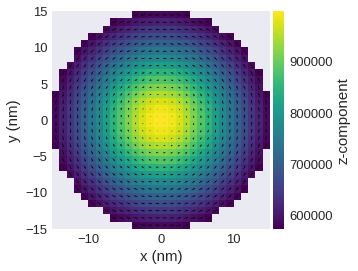

In [6]:
field.sel(z=10e-9).mpl()

The figure is probably too small to see the interesting features of the field we defined. Therefore, we can make it larger by passing `figsize` argument.

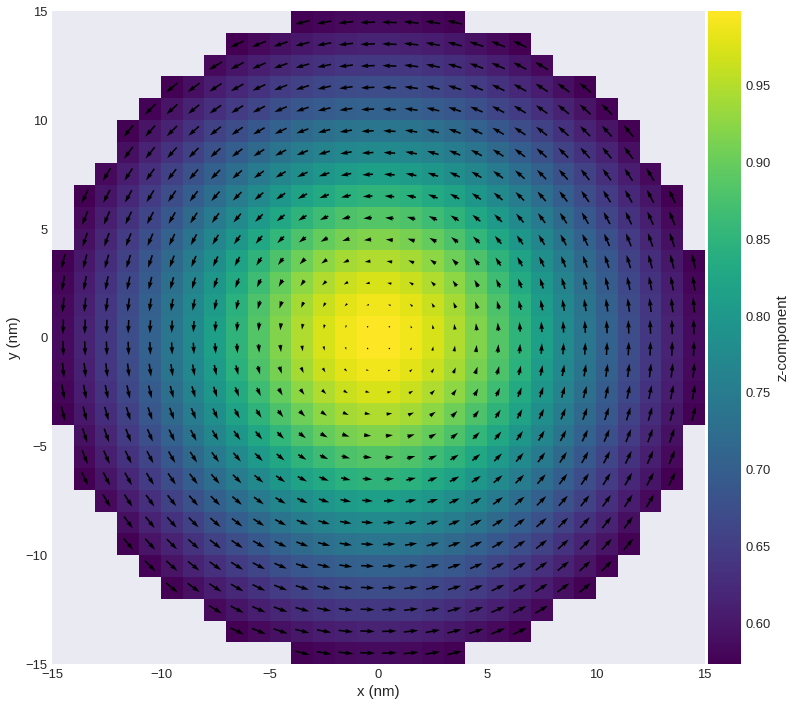

In [7]:
field.orientation.sel(z=10e-9).mpl(figsize=(15, 12))

Now, we can see that we plotted the $z$-plane intersection by looking at the $x$ and $y$ dimensions on the horizontal and vertical axes, respectively. Secondly, we see that there are two overlapped plots: a coloured plot (`scalar`) and a vector plot (`vector`). `vector` plot can only plot two-dimensional vector fields. More precisely, it plots the projection of a vector on the plane we intersected the field with. However, we then lose the information about the out-of-plane component of the vector field. Because of that, there is a scalar (`scalar`) field, together with a colorbar, whose colour depicts the $z$ component of the field. We can also notice, that all discretisation cells where the norm of the field is zero, are not plotted.

Similarly, we can plot a different plane

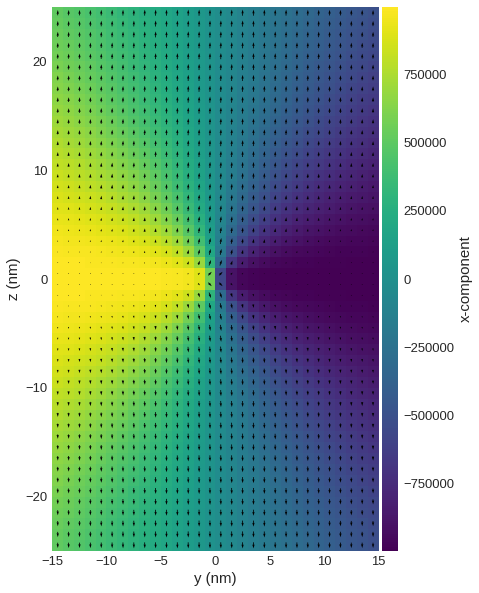

In [8]:
field.sel("x").mpl(figsize=(10, 10))

If there are too many discretisation cells on the plot, their number can decreased using `resample`.

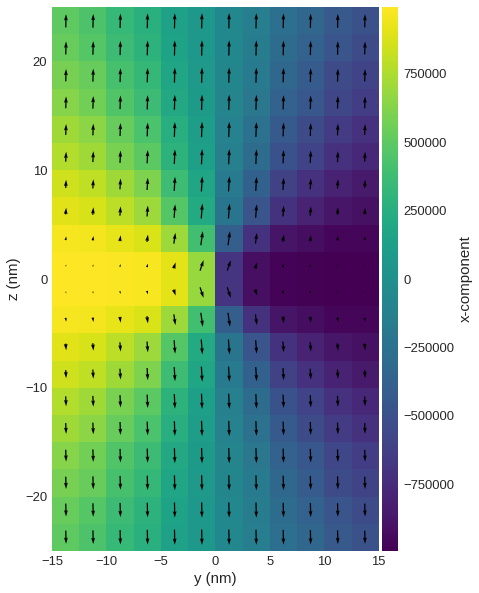

In [9]:
field.sel("x").resample(n=(12, 20)).mpl(figsize=(10, 10))

## Available plotting functions

So far, we showed the default behaviour of `discretisedfield.Field.mpl()`, a convenience function for simple plots. However, it is often required that a custom plot is built. Here, we show the different available plotting functions:

- `discretisedfield.Field.mpl.scalar` for plotting scalar fields
- `discretisedfield.Field.mpl.vector` for plotting vector fields
- `discretisedfield.Field.mpl.contour` for plotting contour lines of scalar fields
- `discretisedfield.Field.mpl.lightness` for HSL plots of scalar or vector fields

`discretisedfield.Field.mpl()` internally combines `discretisedfield.Field.mpl.scalar` and `discretisedfield.Field.mpl.vector`.

In the following we will always plot the field on one of two different planes. To simplify the subsequent calls we first define the planes.

In [10]:
plane_xy = field.sel(z=10e-9)
plane_yz = field.sel("x").resample((12, 20))

### Scalar field visualisation – `mpl.scalar`

First, we simply try to plot the full field using `mpl.scalar`:

In [11]:
try:
    plane_xy.mpl.scalar()
except ValueError as e:
    print("Exception raised:", e)

Exception raised: Cannot plot self.field.nvdim=3 field.


An exception was raised because `mpl.scalar` can only plot scalar fields. Therefore, we are going to extract the $z$ component of the field.

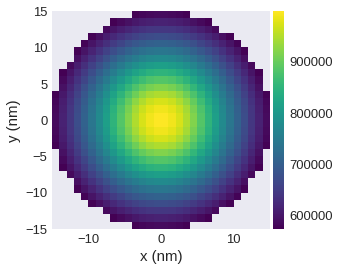

In [12]:
plane_xy.z.mpl.scalar()

Now, we got a plot of the field's $z$ component. However, discretisation cells, which are outside the cylinder, are also plotted. This is because norm cannot be reconstructed from the scalar field passed to `mpl.scalar`. In order to remove the cells where field is zero from the plot, `filter_field` must be passed. The `filter_field` must be defined on a 2d mesh. In the current example the norm does not change along z direction so we can optionally omit the `z` position when selecting a 2d layer.

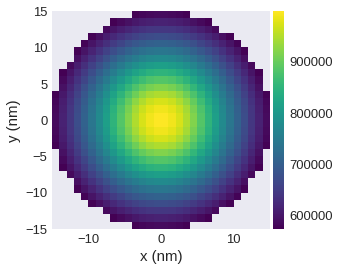

In [13]:
plane_xy.z.mpl.scalar(filter_field=field.norm.sel(z=10e-9))

The colorbar is added to the plot by default. However, we can remove it from the plot.

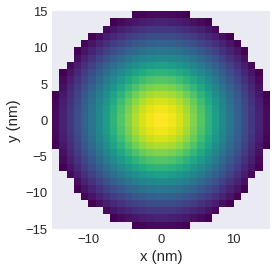

In [14]:
plane_xy.z.mpl.scalar(filter_field=field.norm.sel("z"), colorbar=False)

Similarly, we can change the colorbar label.

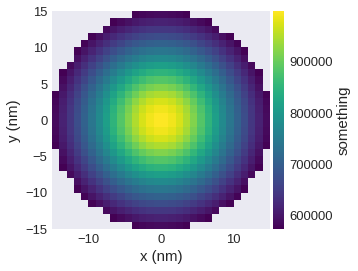

In [15]:
plane_xy.z.mpl.scalar(filter_field=field.norm.sel("z"), colorbar_label="something")

As already seen, we can change the size of the plot.

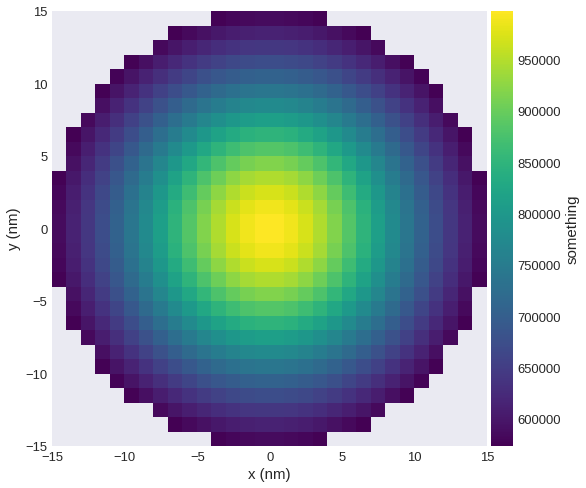

In [16]:
plane_xy.z.mpl.scalar(
    figsize=(12, 8), filter_field=field.norm.sel("z"), colorbar_label="something"
)

Sometimes it is necessary to adjust the limits on the colorbar:

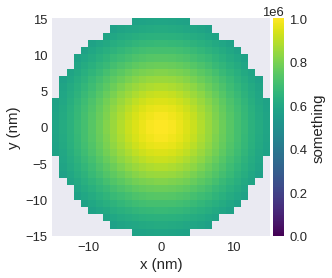

In [17]:
plane_xy.z.mpl.scalar(
    filter_field=field.norm.sel("z"), colorbar_label="something", clim=(0, 1e6)
)

If we have data (symmetrically) arround zero it can be useful to have a symmetric colour bar, i.e. to asign the value zero to the central color. We can do this (without specifying limits manually) by passing `symmetric_clim`. 

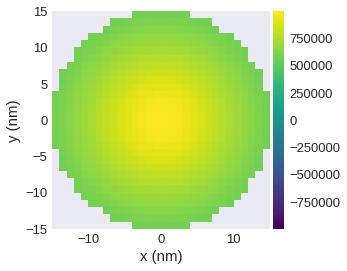

In [18]:
plane_xy.z.mpl.scalar(filter_field=field.norm.sel("z"), symmetric_clim=True)

Multiplier used for axis labels is computed internally, but it can be explicitly changed using `multiplier`.

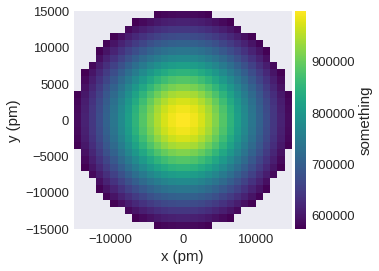

In [19]:
plane_xy.z.mpl.scalar(
    filter_field=field.norm.sel("z"), colorbar_label="something", multiplier=1e-12
)

In order to save the plot, we pass `filename` and the plot is saved as PDF.

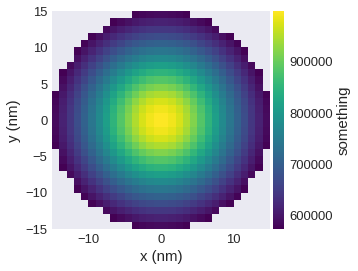

In [20]:
plane_xy.z.mpl.scalar(
    filter_field=field.norm.sel("z"), colorbar_label="something", filename="scalar.pdf"
)

`mpl_scalar` is based on `matplotlib.pyplot.imshow`, so any argument accepted by it can be passed. For its functionality, please refer to the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html). The available colormaps and additional information on the use of colormaps are shown in this [matplotlib tutorial](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

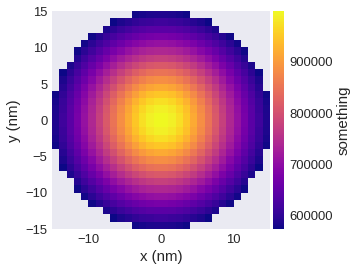

In [21]:
plane_xy.z.mpl.scalar(
    filter_field=field.norm.sel("z"), colorbar_label="something", cmap="plasma"
)

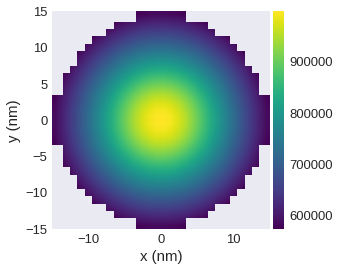

In [22]:
plane_xy.z.mpl.scalar(filter_field=field.norm.sel("z"), interpolation="bilinear")

### Vector field visualisation – `mpl.vector`
The default plot is:

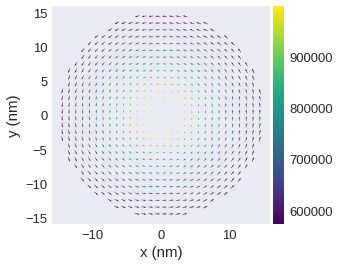

In [23]:
plane_xy.mpl.vector()

By default color is used to show the out-of-plane component. We can reduce the number of vectors.

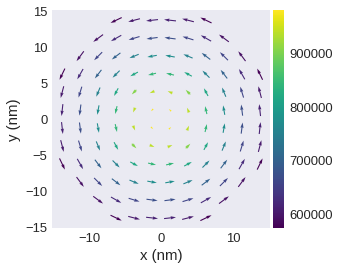

In [24]:
field.sel(z=10e-9).resample((12, 12)).mpl.vector()

We can turn of automatic coloring based on one vector component.

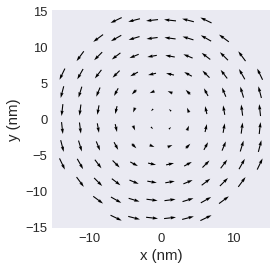

In [25]:
field.sel(z=10e-9).resample(n=(12, 12)).mpl.vector(use_color=False)

Without automatic colouring, we can additionally specify a uniform color.

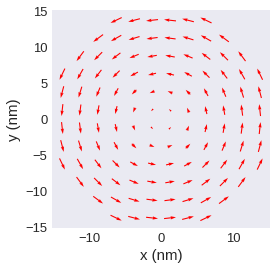

In [26]:
field.sel(z=10e-9).resample((12, 12)).mpl.vector(color="red", use_color=False)

Turn of colorbar.

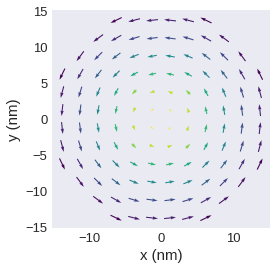

In [27]:
field.sel(z=10e-9).resample((12, 12)).mpl.vector(colorbar=False)

Use a different scalar field for coloring.

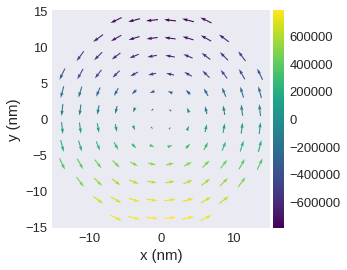

In [28]:
field.sel(z=10e-9).resample((12, 12)).mpl.vector(color_field=field.x.sel(z=10e-9))

Similar to `mpl.scalar` we can 

- add a colourbar label,
- change the colormap,
- change the colormap limit,
- change the multiplier,
- change the figure size,
- and save the plot.

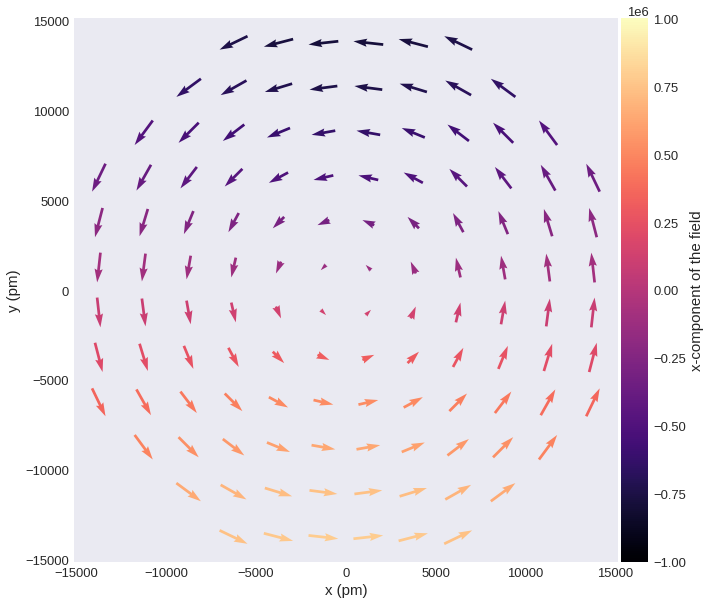

In [29]:
field.sel(z=10e-9).resample(n=(12, 12)).mpl.vector(
    color_field=field.x.sel(z=10e-9),
    colorbar_label="x-component of the field",
    cmap="magma",
    clim=(-1e6, 1e6),
    multiplier=1e-12,
    figsize=(12, 10),
    filename="vector.pdf",
)

We can pass additional keyword arguments to change the quiver style (see `matplotlib.pyplot.quiver` [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html) for details and available arguments).

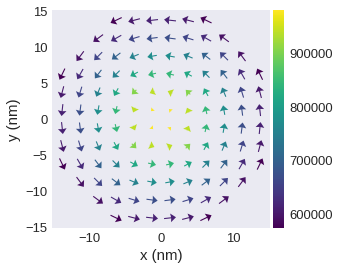

In [30]:
field.sel(z=10e-9).resample((12, 12)).mpl.vector(headwidth=8)

Scale of quivers.

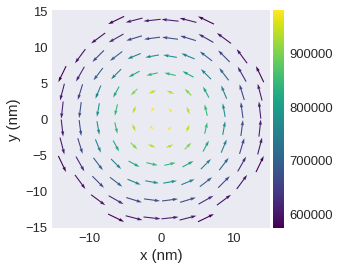

In [31]:
field.sel(z=10e-9).resample((12, 12)).mpl.vector(scale=1e7)

#### 2d vector fields
For 3d vector fields discretisedfield assumes that the first vector component points in spatial x direction, the second in spatial y direction, and the third in spatial z direction. For 2d vector fields we cannot automatically associate components and spatial directions. Therefore, we must explicitly define the components pointing in the plot x and plot y direction by passing `vdims`.

We first create a 2d vector field and assign new component names.

In [32]:
plane_2d = plane_xy.x << plane_xy.y
plane_2d.vdims = ["a", "b"]
plane_2d.vdim_mapping = {"a": "x", "b": "y"}

/home/mlang/repos/ubermag-devtools/repos/discretisedfield/discretisedfield/plotting/mpl_field.py:658: UserWarning: Automatic coloring is only supported for 3d fields. Ignoring "use_color=True".
  warnings.warn(


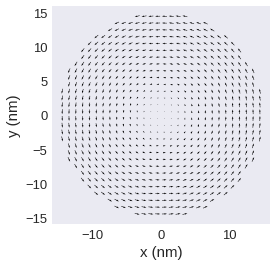

In [33]:
plane_2d.mpl.vector()

First, we assume that the first component `a` would point in spatial x direction and the second in spatial y direction.

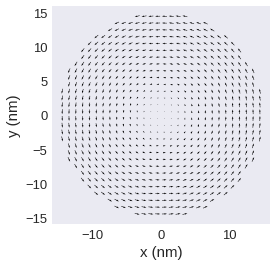

In [34]:
plane_2d.mpl.vector(vdims=["a", "b"])

Now, we assume that component `a` points in spatial y direction and component `b` in spatial z direction. Furthermore, we assume that the field has no component in spatial x direction. Here, we plot an xy plane and hence can only see the y component. We can get such a plot by passing `None` as first argument of `vdims`:

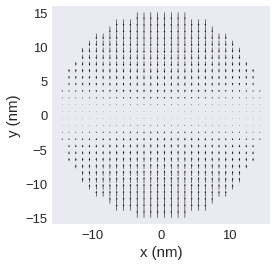

In [35]:
plane_2d.mpl.vector(vdims=[None, "a"])

Similarly, we could assume that `a` points in x and `b` in z direction and we don't have a component in y direction:

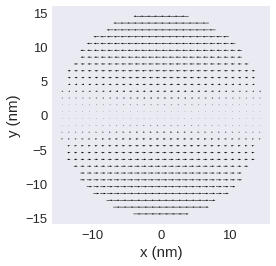

In [36]:
plane_2d.mpl.vector(vdims=["a", None])

We can also pass `vdims` to a 3d vector plot. Here, we swap the first and second component to demonstrate the behaviour. Note, that now the vector `x` component points in spatial y direction and the vector `y` component points in spatial `x` direction which does not make much sense.

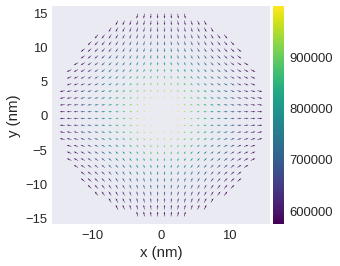

In [37]:
plane_xy.mpl.vector(vdims=["y", "x"])

### Contour line plots – `mpl.contour`
Scalar fields can be plotted as contour line plots.

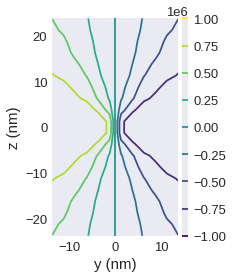

In [38]:
plane_yz.x.mpl.contour()

Similar to `mpl.scalar` it is possible to

- change the `figsize`
- specify a `multiplier`
- specify a `filter_field`
- save the figure by passing `filename`
- control `colorbar` and `colorbar_label`.

Additional keyword arguments can be passed, as `mpl.contour` is based on `matplotlib.pyplot.contour` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html)).

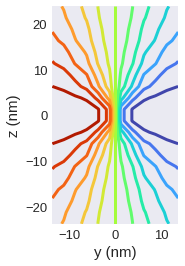

In [39]:
plane_yz.x.mpl.contour(levels=15, cmap="turbo", colorbar=False, linewidths=3)

### HSL plots – `mpl.lightness`

A common way to plot full vector fields is to use the HSV/HSL color scheme. The angle of the in-plane component is then shown by colour, the out-of-plane component by the lightness.

`mpl.lighness` can be used for fields with `dim=1`, `dim=2`, or `dim=3`. For `dim=3` vector fields the out-of-plane component is used for the lightness, otherwise the `norm` is used by default. If no `filter_field` is specified, the norm is used as filter field by default.

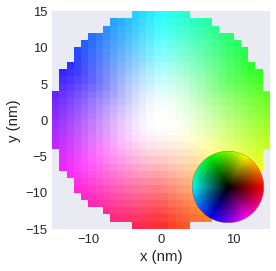

In [40]:
plane_xy.mpl.lightness()

Similar to `mpl.scalar` it is possible to

- change the `figsize`
- specify a `multiplier`
- specify a `filter_field`
- save the figure by passing `filename`.

Instead of a `colorbar` a colorwheel is shown by default. It is possible to show additional labels.

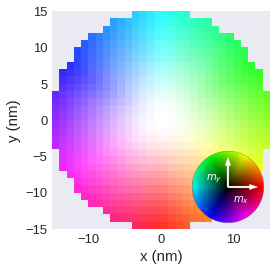

In [41]:
plane_xy.mpl.lightness(colorwheel_xlabel=r"$m_x$", colorwheel_ylabel=r"$m_y$")

Not showing the `colorwheel`.

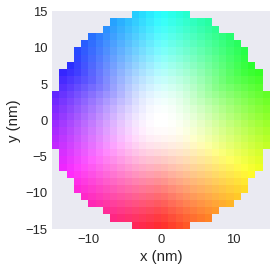

In [42]:
plane_xy.mpl.lightness(colorwheel=False)

Specifying a different `lighness_field`.

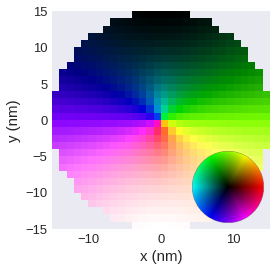

In [43]:
plane_xy.mpl.lightness(lightness_field=field.x.sel(z=10e-9))

Change the lightness range.

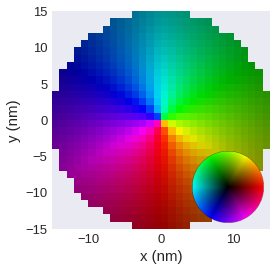

In [44]:
plane_xy.mpl.lightness(clim=(0, 0.5))

#### `colorwheel`
We can pass additional keyword arguments to `colorwheel_args` in the `lighness` plot.

To get more control over the colorwheel the function to draw the colorwheel is exposed an can be used separatly. We have to explicitly give an axis to `add_colorwheel`.

<AxesHostAxes: >

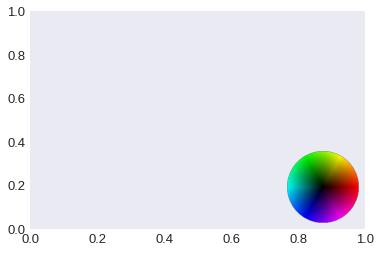

In [45]:
fig, ax = plt.subplots()
df.plotting.mpl_field.add_colorwheel(ax=ax)

We can specify `widht`, `height`, `loc` and additional keyword arguments that can be used for `mpl_toolkits.axes_grid1.inset_locator.inset_axes` ([documentation](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.inset_axes.html)).

<AxesHostAxes: >

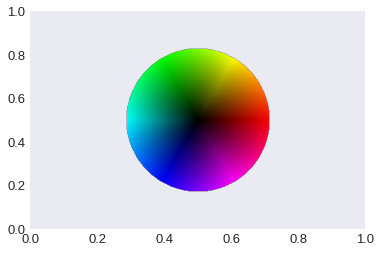

In [46]:
fig, ax = plt.subplots()
df.plotting.mpl_field.add_colorwheel(ax, width=2, height=2, loc="center")

### Combining scalar and vector plots – `mpl()`

In the beginning, we have briefly seen, that we can use the convenience function `mpl()` to generate plots. We can adjust these plots by passing `scalar_kw` or `vector_kw` that are internally passed to `mpl.scalar` and `mpl.vector`, respectivly. All arguments allowed for `mpl.scalar` or `mpl.vector` can be specified. By default `use_color=False` for the quiver plot. To disable automatic filtering add `scalar_kw={'filter_field': None}`.

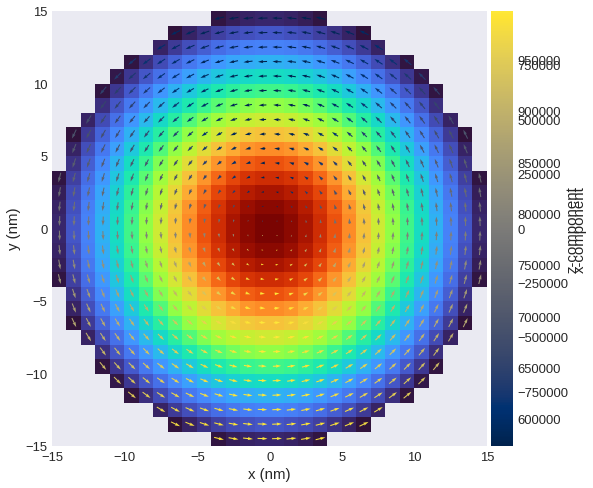

In [47]:
plane_xy.mpl(
    figsize=(12, 8),
    scalar_kw={"cmap": "turbo"},
    vector_kw={
        "cmap": "cividis",
        "use_color": True,
        "color_field": field.x.sel("z"),
        "colorbar": True,
        "colorbar_label": "x-component",
    },
    multiplier=1e-9,
    # filename='mplplot.pdf'
)

If we have a 2d field and want to use `mpl` we have to always pass `vdims` to `vector_kw`.

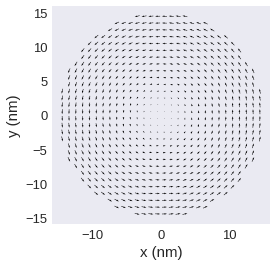

In [48]:
plane_2d.mpl(vector_kw={"vdims": ["a", "b"]})

## Building a custom plot
We can build custom plots by combining the different available plots. This is done via passing axes to the plotting functions. In the following we start with a step-by-step example and then show some additional examples.

First, we manually create the combined `scalar`-`vector` plot similar to the one show in the cell above. We start by creating figure and axes.

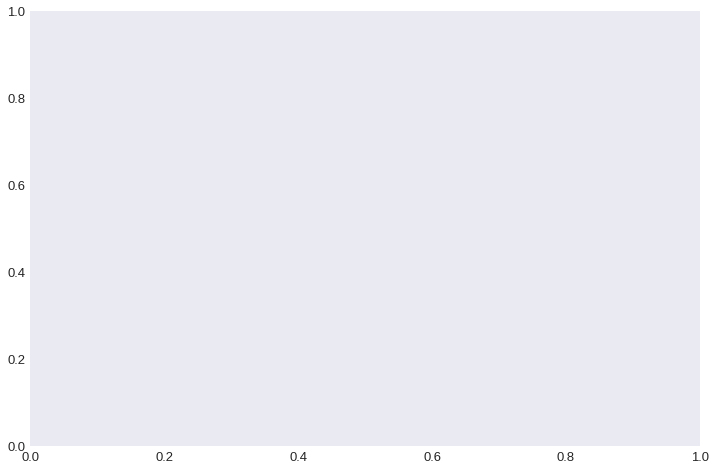

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))

Then we can add the scalar plot of the z-component and pass `ax` as additional argument. We have to manually specify the `filter_field`.

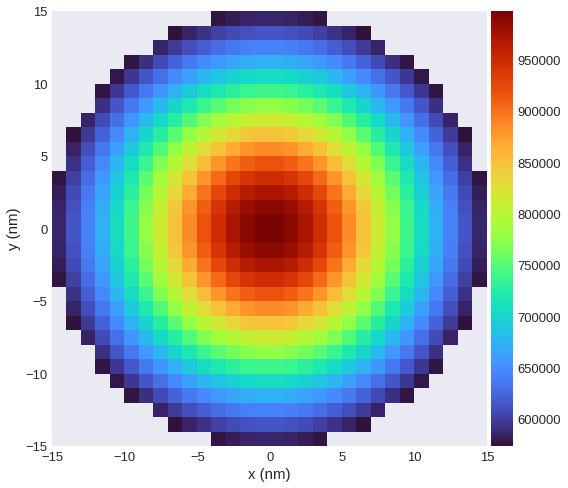

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))
field.sel(z=10e-9).z.mpl.scalar(ax=ax, cmap="turbo")

In the last step we can add the quiver plot using `mpl.vector`. As we now have separate control over `scalar` and `vector` we can reduce the number of `quivers` independently.

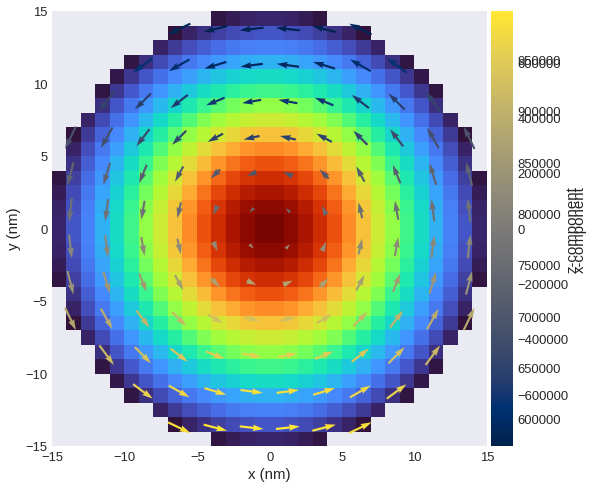

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
field.sel(z=10e-9).z.mpl.scalar(ax=ax, cmap="turbo", colorbar_label="z-component")
field.sel(z=10e-9).resample((12, 12)).mpl.vector(
    ax=ax,
    cmap="cividis",
    color_field=field.x.sel(z=10e-9),
    colorbar_label="x-component",
)

We can combine different plots in different subplots.

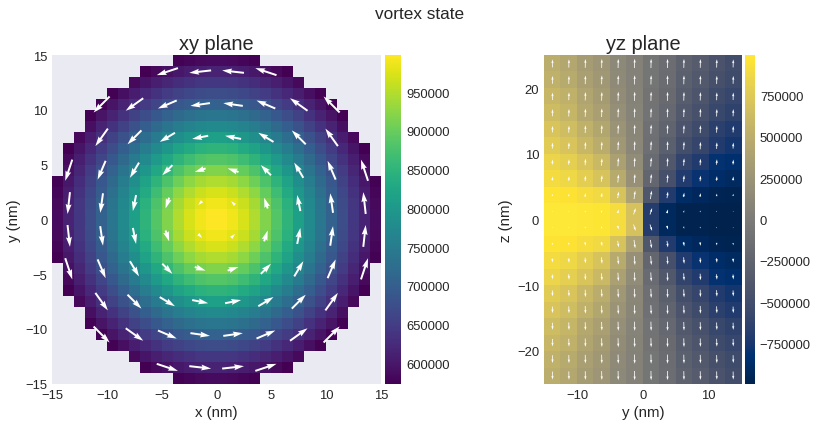

In [55]:
fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
plane_xy.z.mpl(ax=axs[0])
field.sel(z=10e-9).resample((10, 10)).mpl.vector(
    ax=axs[0], use_color=False, color="white"
)
plane_yz.mpl(
    ax=axs[1],
    scalar_kw={"colorbar_label": None, "cmap": "cividis", "symmetric_clim": True},
    vector_kw={"color": "white"},
)
axs[0].set_title("xy plane")
axs[1].set_title("yz plane")
fig.suptitle("vortex state", fontsize="xx-large")
fig.tight_layout()

By exposing axes we can also combine the other plotting functions, e.g. `lightness`, `vector` and `contour`. We use a new field to show this functionality.

In [57]:
import numpy as np


def init_m(p):
    x, y, z = p
    return np.sin(x / 4), np.cos(y / 5), z


mesh = df.Mesh(p1=(0, 0, -5), p2=(40, 40, 5), cell=(1, 1, 1))
field = df.Field(mesh, nvdim=3, value=init_m, norm=1)

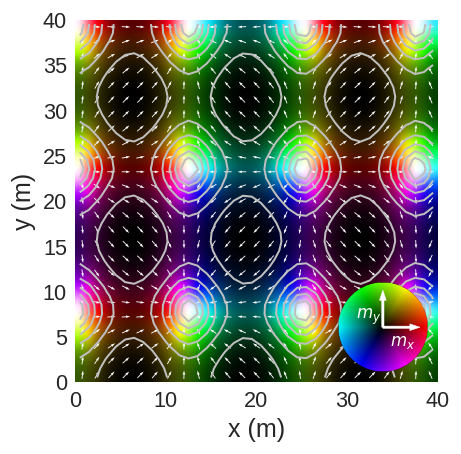

In [72]:
fig, ax = plt.subplots(dpi=120)
field.sel("z").mpl.lightness(
    ax=ax,
    interpolation="spline16",
    colorwheel_args=dict(width=0.75, height=0.75),
    colorwheel_xlabel=r"$m_x$",
    colorwheel_ylabel=r"$m_y$",
    # clim=(0, 1),
)
field.sel("z").resample(n=(25, 25)).mpl.vector(ax=ax, use_color=False, color="w")
field.sel("z").z.mpl.contour(
    ax=ax, levels=6, colors="#bfbfbf", colorbar=False, linewidths=1.2
)

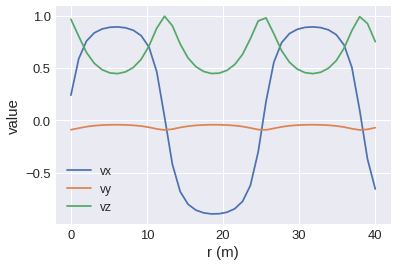

In [76]:
# values at the top boundary
field.line(p1=(0, 40, 0), p2=(40, 40, 0), n=40).mpl()

## [DEPRECATED] Interactive plots

**Note:** We strongly recommend to use the new `field.hvplot` interface instead of the widgets-based approach demonstrated here. The documentation for `hvplot` can be found in a separate notebook.

We can create interactive plots based on `Ipython Widgets`. We define a new field to demonstrate the different interactive plots.

In [55]:
p1 = (-5e-9, -5e-9, -2e-9)
p2 = (5e-9, 5e-9, 10e-9)
cell = (1e-9, 1e-9, 1e-9)
mesh = df.Mesh(p1=p1, p2=p2, cell=cell)

value_fun = lambda pos: (pos[0], pos[1], pos[2])


def norm_fun(pos):
    x, y, z = pos
    if x**2 + y**2 < 5e-9**2:
        return 1
    else:
        return 0


field = df.Field(mesh, dim=3, value=value_fun, norm=norm_fun)

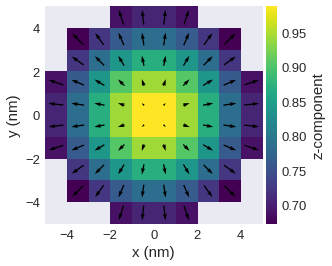

In [56]:
field.plane("z").mpl()

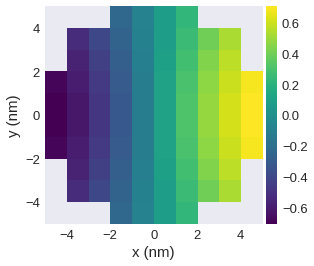

In [57]:
field.x.plane("z").mpl()

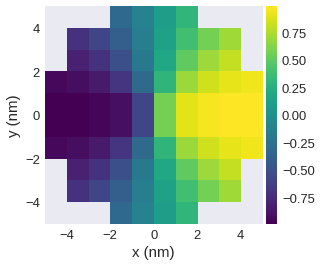

In [58]:
field.x.plane(z=0).mpl()

_NOTE_:

- Interactive plots cannot be displayed on the static website
- Widgets work best in Jupyter notebook. Inside Jupyter lab, if the plot does not update correctly, try adding `plt.show()` at the end of the function.

In [59]:
# NBVAL_IGNORE_OUTPUT
@df.interact(z=field.mesh.slider("z"))
def myplot(z):
    field.x.plane(z=z).mpl()

interactive(children=(SelectionSlider(description='z (nm)', index=6, options=((-1.5, -1.5000000000000002e-09),…

In [60]:
# NBVAL_IGNORE_OUTPUT
@df.interact(z=field.mesh.slider("z", continuous_update=False))
def myplot(z):
    field.x.plane(z=z).mpl()

interactive(children=(SelectionSlider(continuous_update=False, description='z (nm)', index=6, options=((-1.5, …

In [61]:
# NBVAL_IGNORE_OUTPUT
@df.interact(
    z=field.mesh.slider("z", continuous_update=False),
    component=field.mesh.axis_selector(),
)
def myplot(z, component):
    getattr(field, component).plane(z=z).mpl(figsize=(6, 6))

interactive(children=(SelectionSlider(continuous_update=False, description='z (nm)', index=6, options=((-1.5, …

In [62]:
# NBVAL_IGNORE_OUTPUT
@df.interact(
    z=field.mesh.slider("z", continuous_update=False),
    component=field.mesh.axis_selector(widget="radiobuttons", description="component"),
)
def myplot(z, component):
    getattr(field, component).plane(z=z).mpl(figsize=(6, 6))

interactive(children=(SelectionSlider(continuous_update=False, description='z (nm)', index=6, options=((-1.5, …

In [63]:
# NBVAL_IGNORE_OUTPUT
@df.interact(z=field.mesh.slider("z", continuous_update=False))
def myplot(z):
    field.plane(z=z).mpl(figsize=(6, 6))

interactive(children=(SelectionSlider(continuous_update=False, description='z (nm)', index=6, options=((-1.5, …

## Plotting field values along the line

Sometimes it is necessary to explore the field values along a certain line. More precisely, to plot the field values along a line defined between two points. We again use the vortex field. Firstly, we need to obtain $z$ values of the field on a line between $(-15\,\mathrm{nm}, 0, 0)$ and $(15\,\mathrm{nm}, 0, 0)$ at $n=20$ points.

In [64]:
line = vortex_field.mesh.line(p1=(-15e-9, 0, 0), p2=(15e-9, 0, 0), n=20)
field_values = []
parameter = []
for point in line:
    x, y, z = point
    parameter.append(x)  # remember x-position for plot
    field_values.append(vortex_field(point))

# extract mx, my, mz as lists from lists of (mx, my, mz):
mx, my, mz = zip(*field_values)

Now, we can plot the field values along the line:

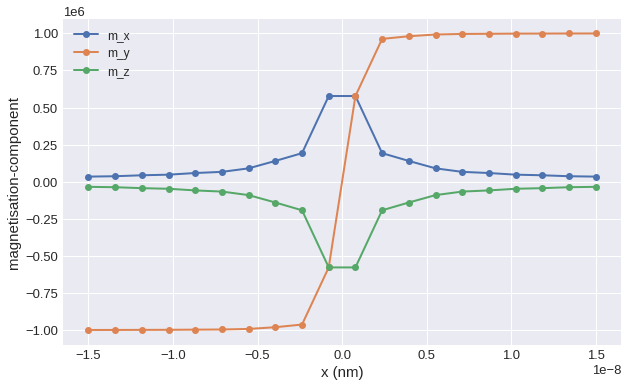

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(parameter, mx, "o-", linewidth=2, label="m_x")
plt.plot(parameter, my, "o-", linewidth=2, label="m_y")
plt.plot(parameter, mz, "o-", linewidth=2, label="m_z")
plt.xlabel("x (nm)")
plt.ylabel("magnetisation-component")
plt.grid()
plt.legend()